# Exploring Learned Representations with XOR

This notebook explores how neural networks learn internal representations through various experiments and visualizations.

## Setup

### Get all the necessary files

In [11]:
import os

if os.path.exists("CVIMR"):
    print("You already have all the components to run this notebook. Please run the test setup script anyway to ensure that the setup is correct!")
else:
    !git clone https://github.com/lorenzo-27/CVIMR.git
    print("CVIMR repository cloned successfully. Please run the test setup script anyway to ensure that the setup is correct!")

You already have all the components to run this notebook. Please run the test setup script anyway to ensure that the setup is correct!


### Install the package
Install the **CVIMR** package, using the appropriate path for Colab or Local environments.

In [12]:
if os.path.exists("../content"): # Colab
  !pip install -e CVIMR/
else: # Local
  !pip install -e .

Obtaining file:///Users/air27/PycharmProjects/CVIMR
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for CVIMR (pyproject.toml) ... done
  Created wheel for CVIMR: filename=cvimr-1.0.0-0.editable-py3-none-any.whl size=4764 sha256=a47d0ba9f6e72f630f374f4890360bb524d58291923f63d5bdd67719bc71e31d
  Stored in directory: /private/var/folders/gh/4wlq1pgs45nc0n62j8t88j1c0000gn/T/pip-ephem-wheel-cache-yeqhb5g7/wheels/06/fd/53/665ef9e10096b5690179cdc7ee266e1f840484c5a2c5a80a9e
Successfully built CVIMR
  Attempting uninstall: CVIMR
    Found existing installation: CVIMR 1.0.0
    Not uninstalling cvimr at /Users/air27/PycharmProjects/CVIMR, outside environment /Users/air27/PycharmProjects/CVIMR/.venv
    Can't uninstall 'CVIMR'. No files were found to uninstall.


### Test setup and verify all components work correctly.

In [13]:
if os.path.exists("../content"): # Colab
  !python3 CVIMR/CVIMR/test_setup.py
else: # Local
  !python3 CVIMR/test_setup.py

╭──────────────────────────────────────────╮
│ XOR Representation Learning - Setup Test │
│ Testing all components...                │
╰──────────────────────────────────────────╯

Testing imports...
┌──────────────┬───┐
│ PyTorch      │ ✓ │
│ NumPy        │ ✓ │
│ Matplotlib   │ ✓ │
│ Scikit-learn │ ✓ │
│ Rich         │ ✓ │
└──────────────┴───┘

Testing custom modules...
✓ All custom modules imported successfully

Testing device detection...
┌────────────────┬───────┐
│ Device         │ mps   │
│ CUDA available │ False │
│ MPS available  │ True  │
└────────────────┴───────┘

Testing model creation...
✓ RELU: 9 parameters
✓ TANH: 9 parameters
✓ SIGMOID: 9 parameters
✓ Identity initialization works

Testing data generation...
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Dataset   ┃ Shape                ┃ Labels ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ XOR       │ torch.Size([4, 2])   │ 2      │
│ 3D XOR    │ torch.Size([8, 3])   │ 2      │
│ Two Moons │ torch.Size([50, 2])  │

### Imports & setup

In [14]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from rich.console import Console

# Import custom modules
if os.path.exists("../../content"): # Colab
  from CVIMR.CVIMR.model import TwoLayerNet, get_device
  from CVIMR.CVIMR.data import (generate_xor, generate_3input_xor,
                          generate_two_moons, generate_spiral, generate_circles)
  from CVIMR.CVIMR.training import train_model, compute_accuracy
  from CVIMR.CVIMR.visualization import (plot_weight_trajectories,
                                  plot_activation_histograms, plot_3d_latent_pca,
                                  create_latent_animation)
else: # Local
  from CVIMR.model import TwoLayerNet, get_device
  from CVIMR.data import (generate_xor, generate_3input_xor,
                          generate_two_moons, generate_spiral, generate_circles)
  from CVIMR.training import train_model, compute_accuracy
  from CVIMR.visualization import (plot_weight_trajectories,
                                  plot_activation_histograms, plot_3d_latent_pca,
                                  create_latent_animation)

console = Console()

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Get device
device = get_device()
console.print(f"[bold green]Using device: {device}[/bold green]")

Using device: mps

## Experiment 1: Classic XOR with Different Activation Functions

We train three models with different activation functions (ReLU, Tanh, Sigmoid)
and compare their learned representations.

In [15]:
# Generate XOR data
x_data, y_data = generate_xor()
console.print(f"[bold]XOR Dataset:[/bold]")
console.print(f"X: {x_data}")
console.print(f"Y: {y_data}")

XOR Dataset:

X: tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

Y: tensor([[0.],
        [1.],
        [1.],
        [0.]])

In [16]:
# Train models with different activations
activations = ['relu', 'tanh', 'sigmoid']
histories = {}
models = {}

for activation in activations:
    console.print(f"\n[bold cyan]Training with {activation.upper()} activation[/bold cyan]")

    # Create and initialize model
    model = TwoLayerNet(input_dim=2, hidden_dim=2, output_dim=1, activation=activation)
    try:
        model.initialize_identity()
    except:
        pass  # Skip if not 2x2

    # Train model
    history = train_model(
        model=model,
        x_data=x_data,
        y_data=y_data,
        lr=0.1,
        max_epochs=10000,
        threshold=1e-5,
        device=device,
        record_interval=10,
        use_bce=True
    )

    histories[activation] = history
    models[activation] = model

    # Test accuracy
    accuracy = compute_accuracy(model, x_data, y_data, device=device)
    console.print(f"[bold green]Final Accuracy: {accuracy:.4f}[/bold green]")

Training with RELU activation

Training on mps...

Output()

Epoch 0: Loss 0.708497, Accuracy 0.5000

Epoch 1000: Loss 0.355213, Accuracy 0.7500

Epoch 2000: Loss 0.348804, Accuracy 0.7500

Epoch 3000: Loss 0.347789, Accuracy 0.7500

Epoch 4000: Loss 0.347375, Accuracy 0.7500

Epoch 5000: Loss 0.347143, Accuracy 0.7500

Epoch 6000: Loss 0.347071, Accuracy 0.7500

Epoch 7000: Loss 0.346940, Accuracy 0.7500

Epoch 8000: Loss 0.346882, Accuracy 0.7500

Epoch 9000: Loss 0.346848, Accuracy 0.7500

Training finished after 10000 epochs

Final loss: 0.346803

Final Accuracy: 0.7500

Training with TANH activation

Training on mps...

Output()

Epoch 0: Loss 0.813874, Accuracy 0.5000

Epoch 1000: Loss 0.525166, Accuracy 0.7500

Epoch 2000: Loss 0.345894, Accuracy 0.7500

Epoch 3000: Loss 0.034834, Accuracy 1.0000

Epoch 4000: Loss 0.016928, Accuracy 1.0000

Epoch 5000: Loss 0.011077, Accuracy 1.0000

Epoch 6000: Loss 0.008206, Accuracy 1.0000

Epoch 7000: Loss 0.006507, Accuracy 1.0000

Epoch 8000: Loss 0.005386, Accuracy 1.0000

Epoch 9000: Loss 0.004592, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.004001

Final Accuracy: 1.0000

Training with SIGMOID activation

Training on mps...

Output()

Epoch 0: Loss 0.751298, Accuracy 0.5000

Epoch 1000: Loss 0.692692, Accuracy 0.5000

Epoch 2000: Loss 0.689902, Accuracy 0.7500

Epoch 3000: Loss 0.661512, Accuracy 0.7500

Epoch 4000: Loss 0.545947, Accuracy 0.7500

Epoch 5000: Loss 0.366957, Accuracy 1.0000

Epoch 6000: Loss 0.126089, Accuracy 1.0000

Epoch 7000: Loss 0.061650, Accuracy 1.0000

Epoch 8000: Loss 0.039367, Accuracy 1.0000

Epoch 9000: Loss 0.028593, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.022339

Final Accuracy: 1.0000

### Visualization: Latent Space Trajectories

The following code cell plots the **latent space trajectories** of samples during model training, comparing different activation functions. The latent space represents a compact projection of the learned features, where each point corresponds to the model’s internal state for a given sample. These trajectories illustrate how the representations evolve across epochs (recorded every 10 epochs - `record_interval=10`), showing how the model gradually separates the data. Each curve starts at the initial point (square) and ends at the final point (circle) in the 2D latent space.

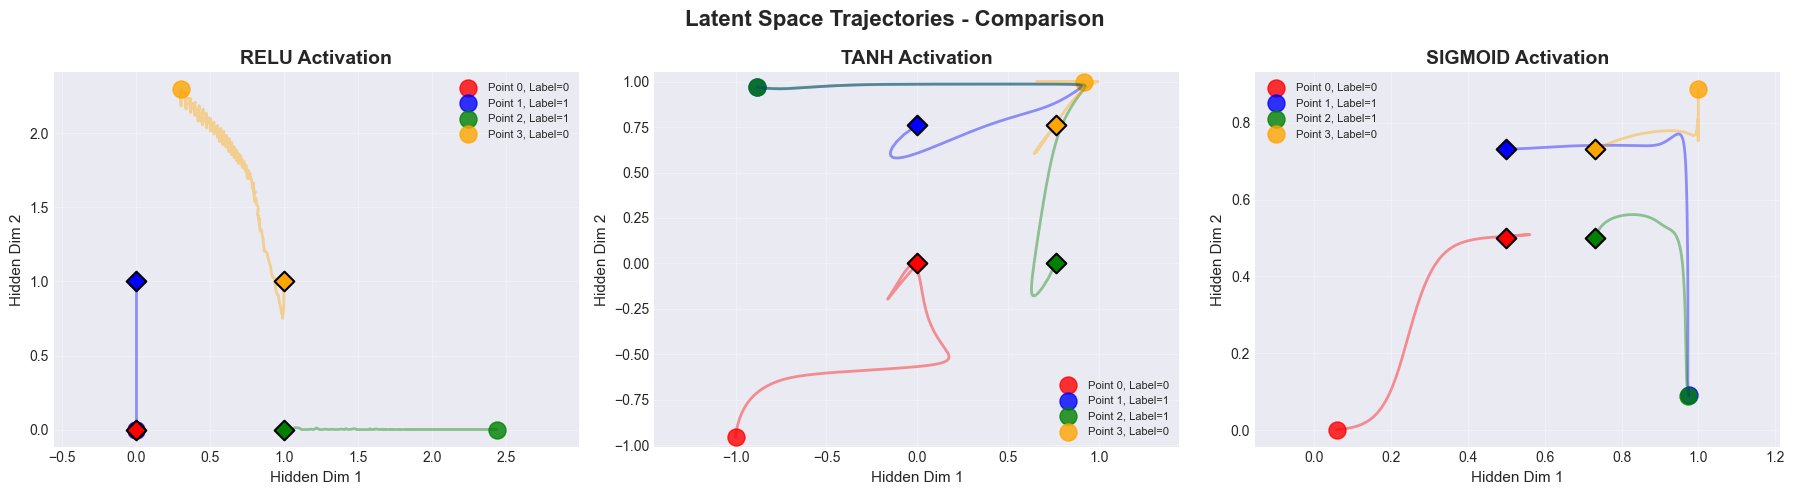

In [17]:
# Plot latent trajectories for each activation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, activation in enumerate(activations):
    ax = axes[idx]
    latent_history = histories[activation].get_latent_tensor()

    colors = ["red", "blue", "green", "orange"]
    n_samples = latent_history.shape[1]

    for i in range(n_samples):
        coords = latent_history[:, i, :]
        label_val = int(y_data[i].item())

        # Plot trajectory
        ax.plot(coords[:, 0], coords[:, 1], color=colors[i],
                alpha=0.4, linewidth=2)

        # Starting position
        ax.scatter(coords[0, 0], coords[0, 1], color=colors[i],
                   marker='D', s=100, edgecolors='black',
                   linewidths=1.5, alpha=1.0, zorder=5)

        # Final position
        ax.scatter(coords[-1, 0], coords[-1, 1], color=colors[i],
                   alpha=0.8, marker='o', s=150,
                   label=f"Point {i}, Label={label_val}")

    ax.set_title(f"{activation.upper()} Activation", fontsize=14, fontweight='bold')
    ax.set_xlabel("Hidden Dim 1", fontsize=11)
    ax.set_ylabel("Hidden Dim 2", fontsize=11)
    ax.axis("equal")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

    # Create animation of latent space evolution
    #anim = create_latent_animation(
    #    latent_history=latent_history,
    #    y_data=y_data,
    #    filename=f"latent_evolution_{activation}.gif",
    #    interval=100,
    #    title="Latent Space Evolution During Training"
    #)

plt.suptitle("Latent Space Trajectories - Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualization: Decision Boundaries

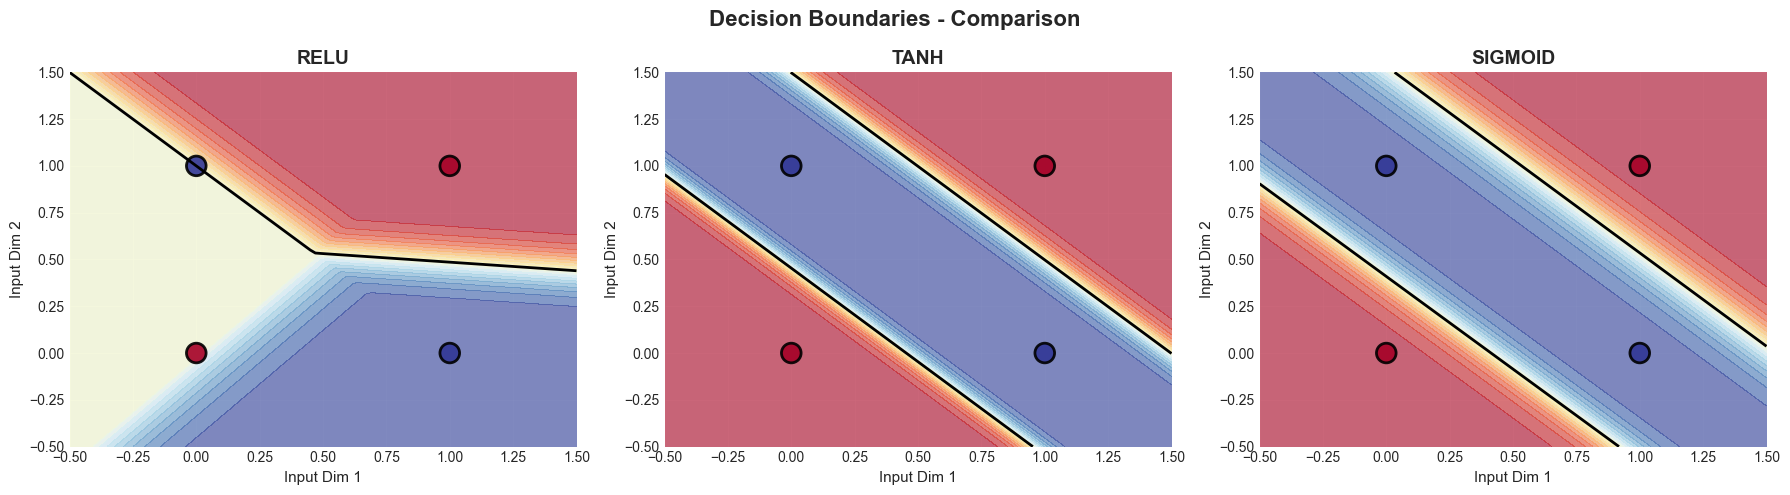

In [18]:
# Plot decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, activation in enumerate(activations):
    model = models[activation]
    model.eval()

    # Create mesh grid
    resolution = 100
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        predictions, _ = model(grid_points)
        predictions = torch.sigmoid(predictions).cpu().numpy()

    predictions = predictions.reshape(xx.shape)

    # Plot
    ax = axes[idx]
    contour = ax.contourf(xx, yy, predictions, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, predictions, levels=[0.5], colors='black', linewidths=2)

    # Data points
    x_np = x_data.cpu().numpy()
    y_np = y_data.cpu().numpy().ravel()
    ax.scatter(x_np[:, 0], x_np[:, 1], c=y_np,
               cmap='RdYlBu', s=200, edgecolors='black',
               linewidths=2, alpha=0.9)

    ax.set_title(f"{activation.upper()}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Input Dim 1", fontsize=11)
    ax.set_ylabel("Input Dim 2", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle("Decision Boundaries - Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualization: Training Loss Curves

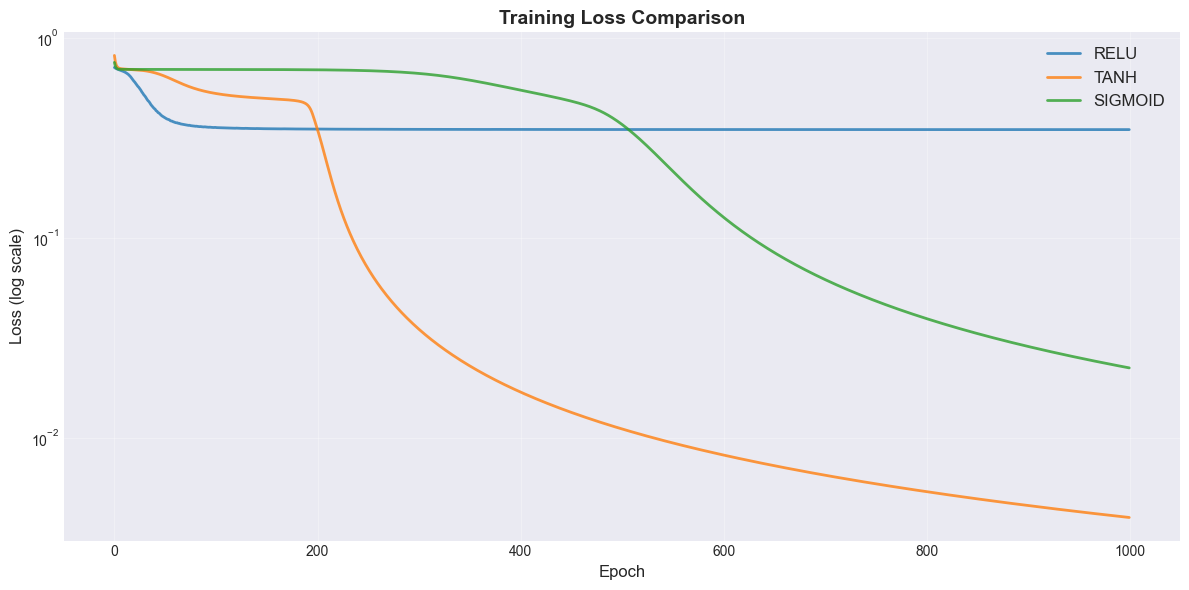

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

for activation in activations:
    epochs = range(len(histories[activation].losses))
    ax.plot(epochs, histories[activation].losses,
            linewidth=2, label=activation.upper(), alpha=0.8)

ax.set_yscale('log')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (log scale)", fontsize=12)
ax.set_title("Training Loss Comparison", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization: Weight Trajectories

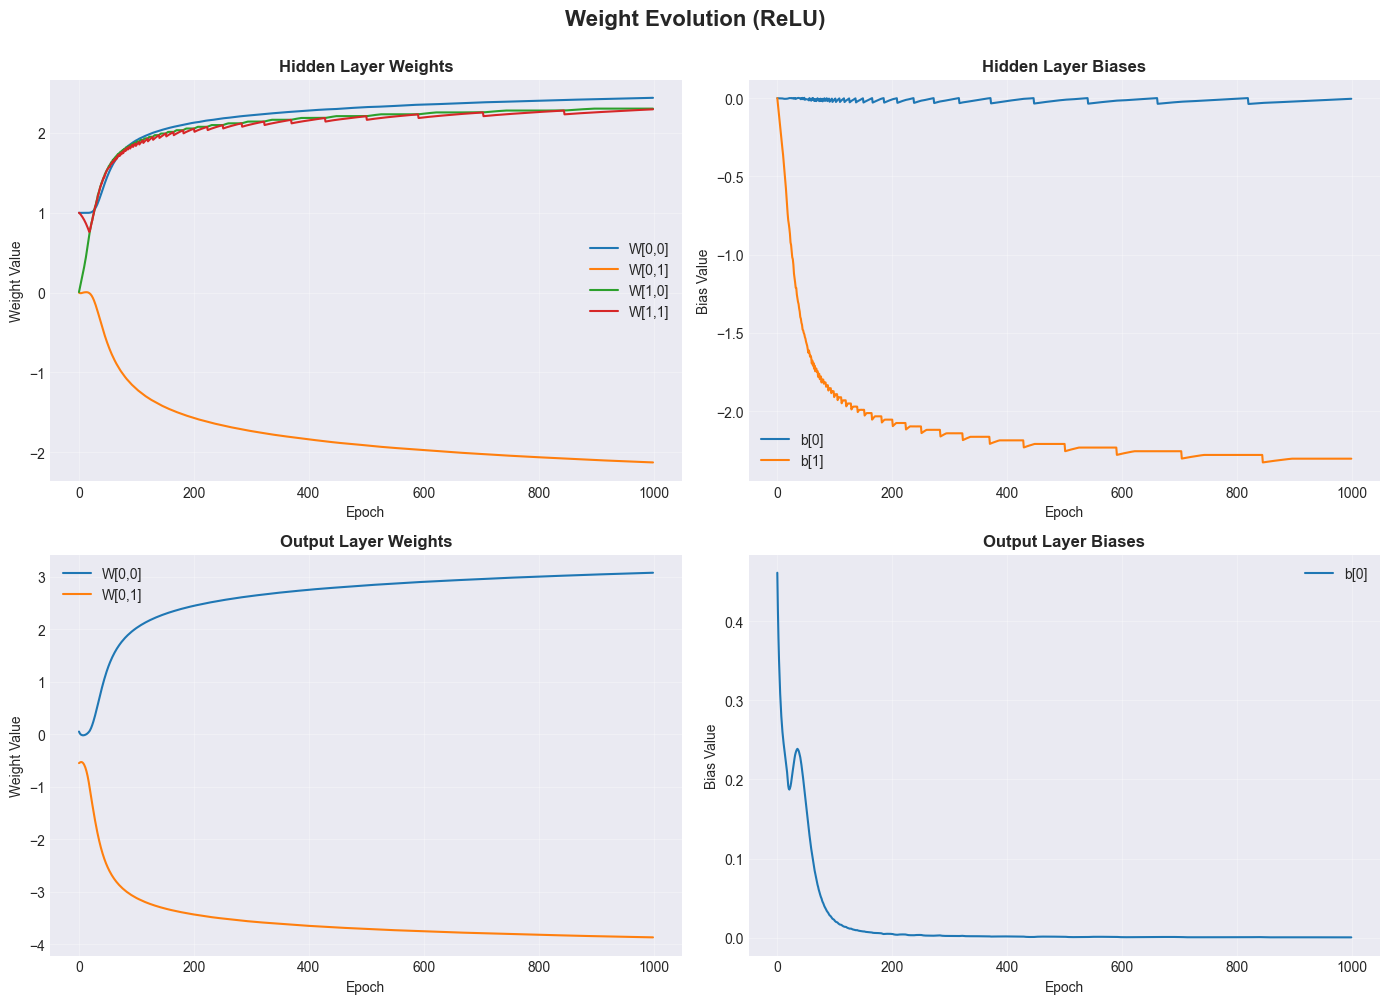

In [20]:
# Plot weight evolution for ReLU (most interesting)
fig = plot_weight_trajectories(histories['relu'],
                               title="Weight Evolution (ReLU)")
plt.show()

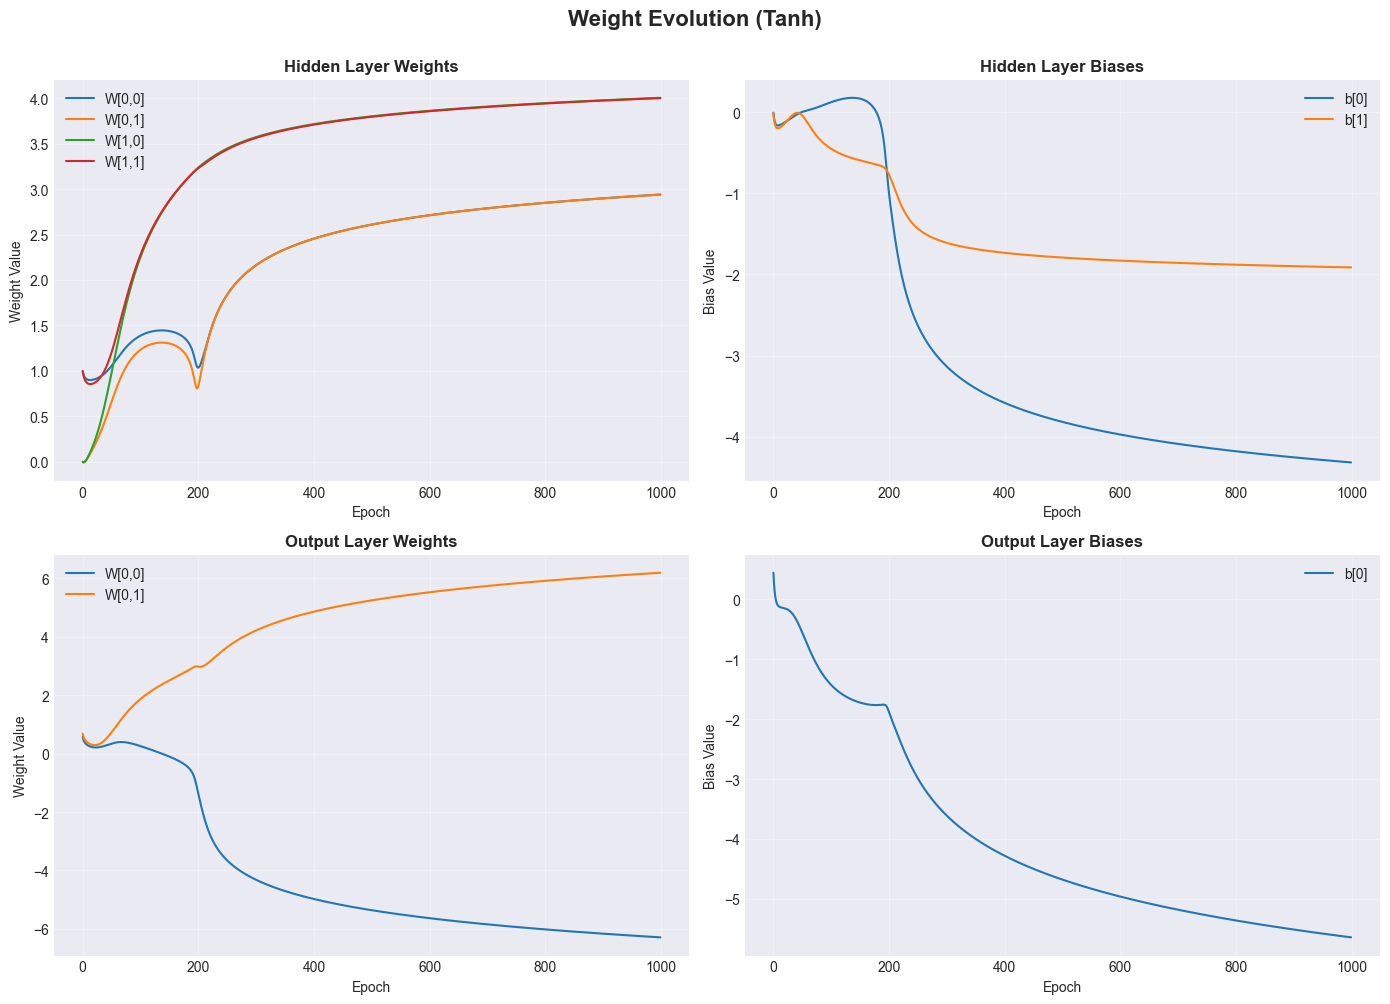

In [21]:
# Plot weight evolution for Tanh
fig = plot_weight_trajectories(histories['tanh'],
                               title="Weight Evolution (Tanh)")
plt.show()

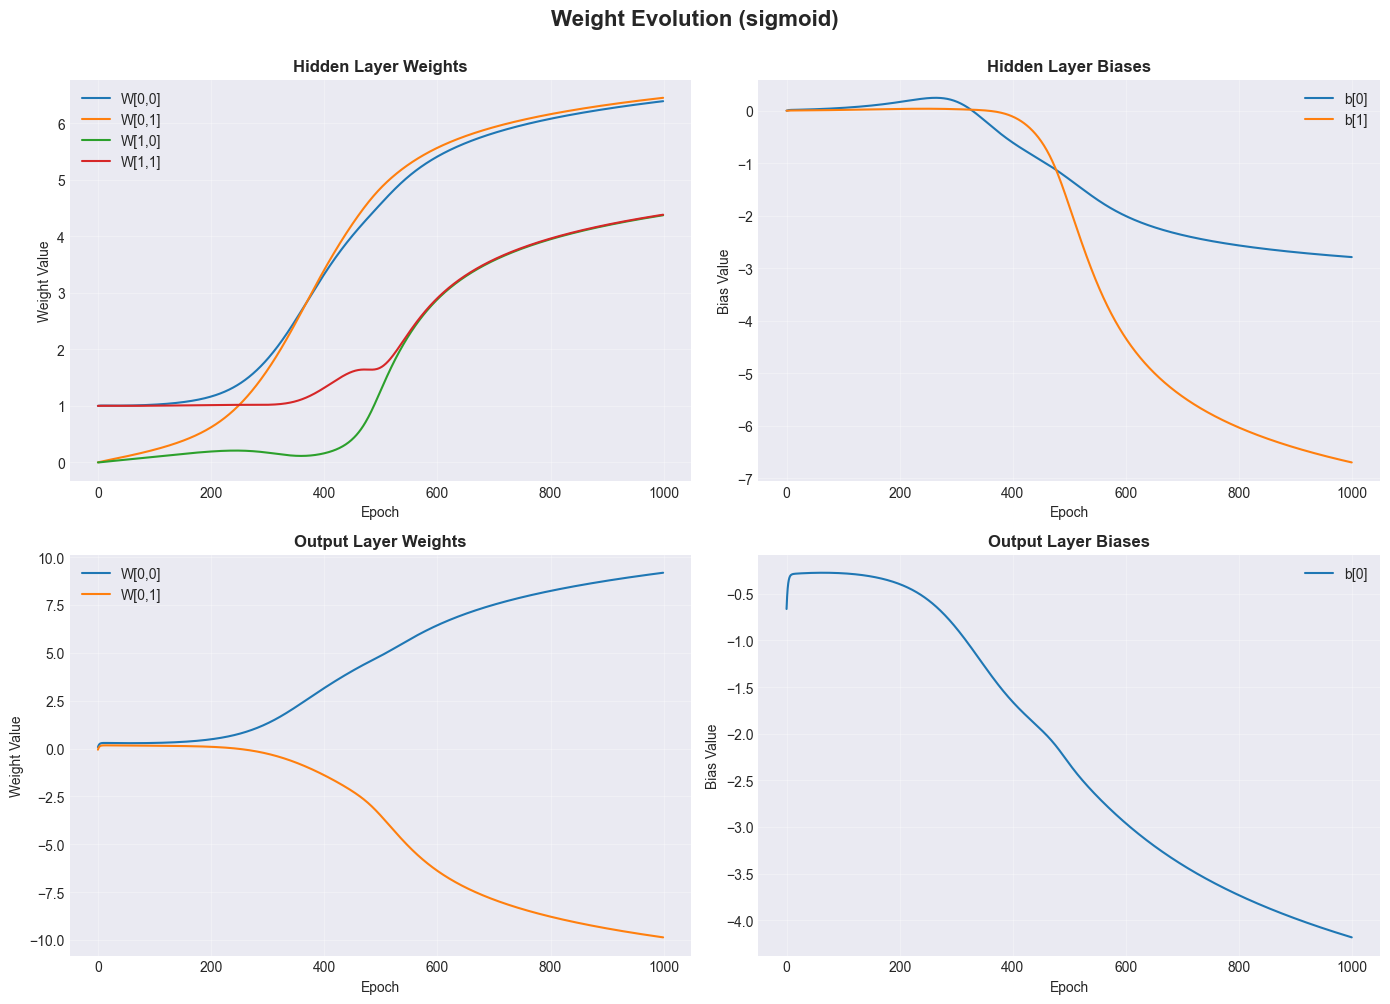

In [22]:
# Plot weight evolution for Sigmoid
fig = plot_weight_trajectories(histories['sigmoid'],
                               title="Weight Evolution (sigmoid)")
plt.show()

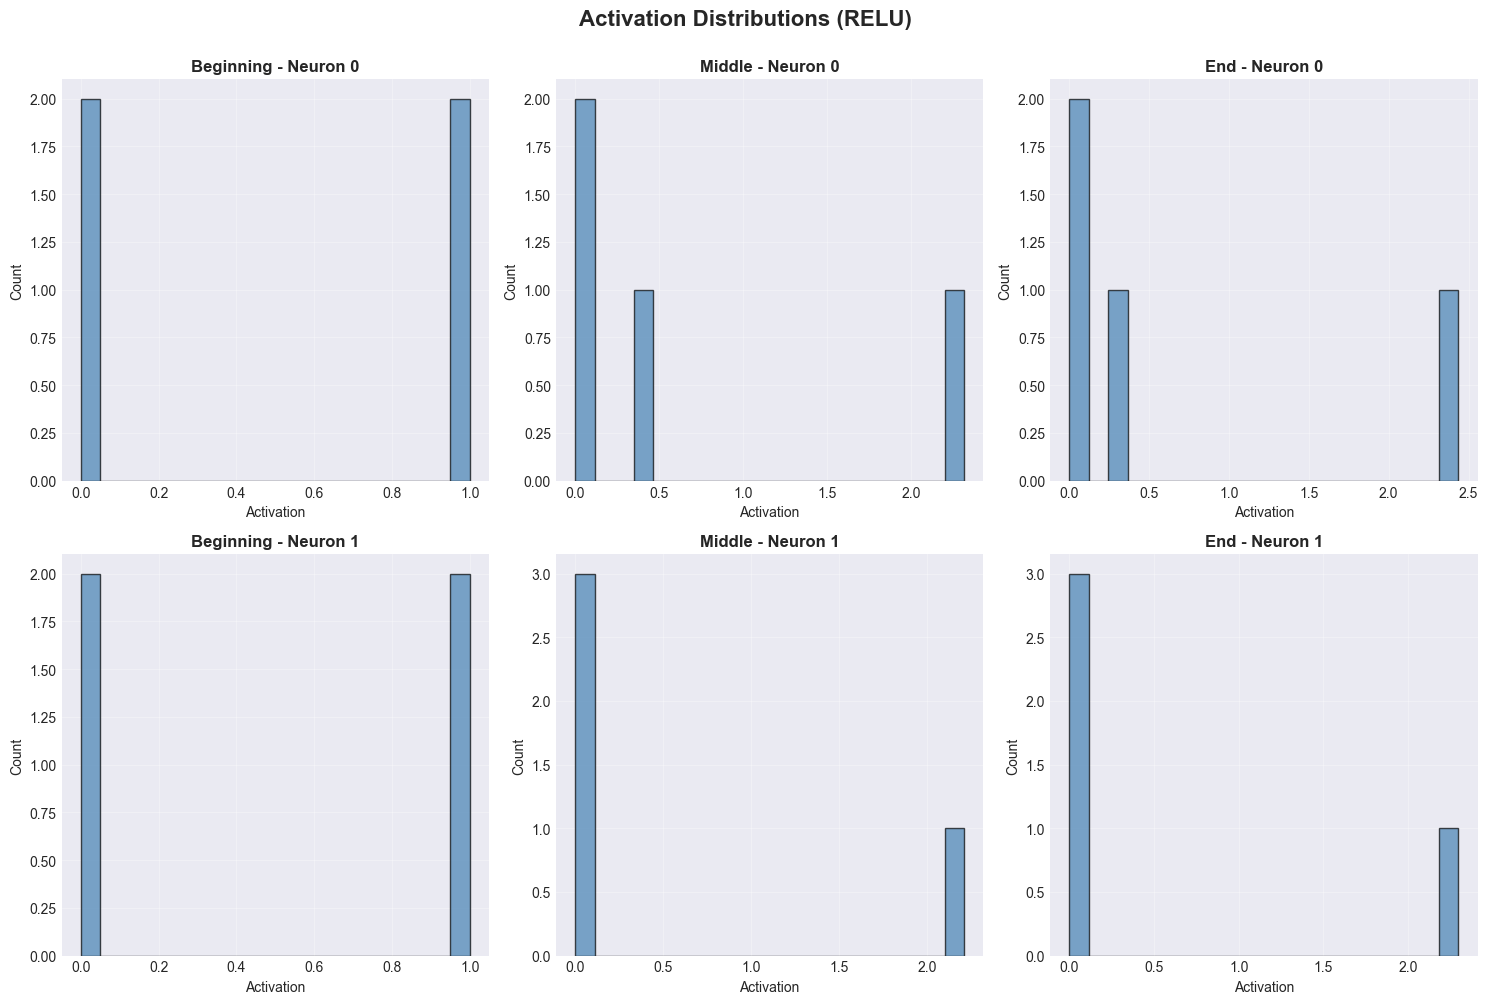

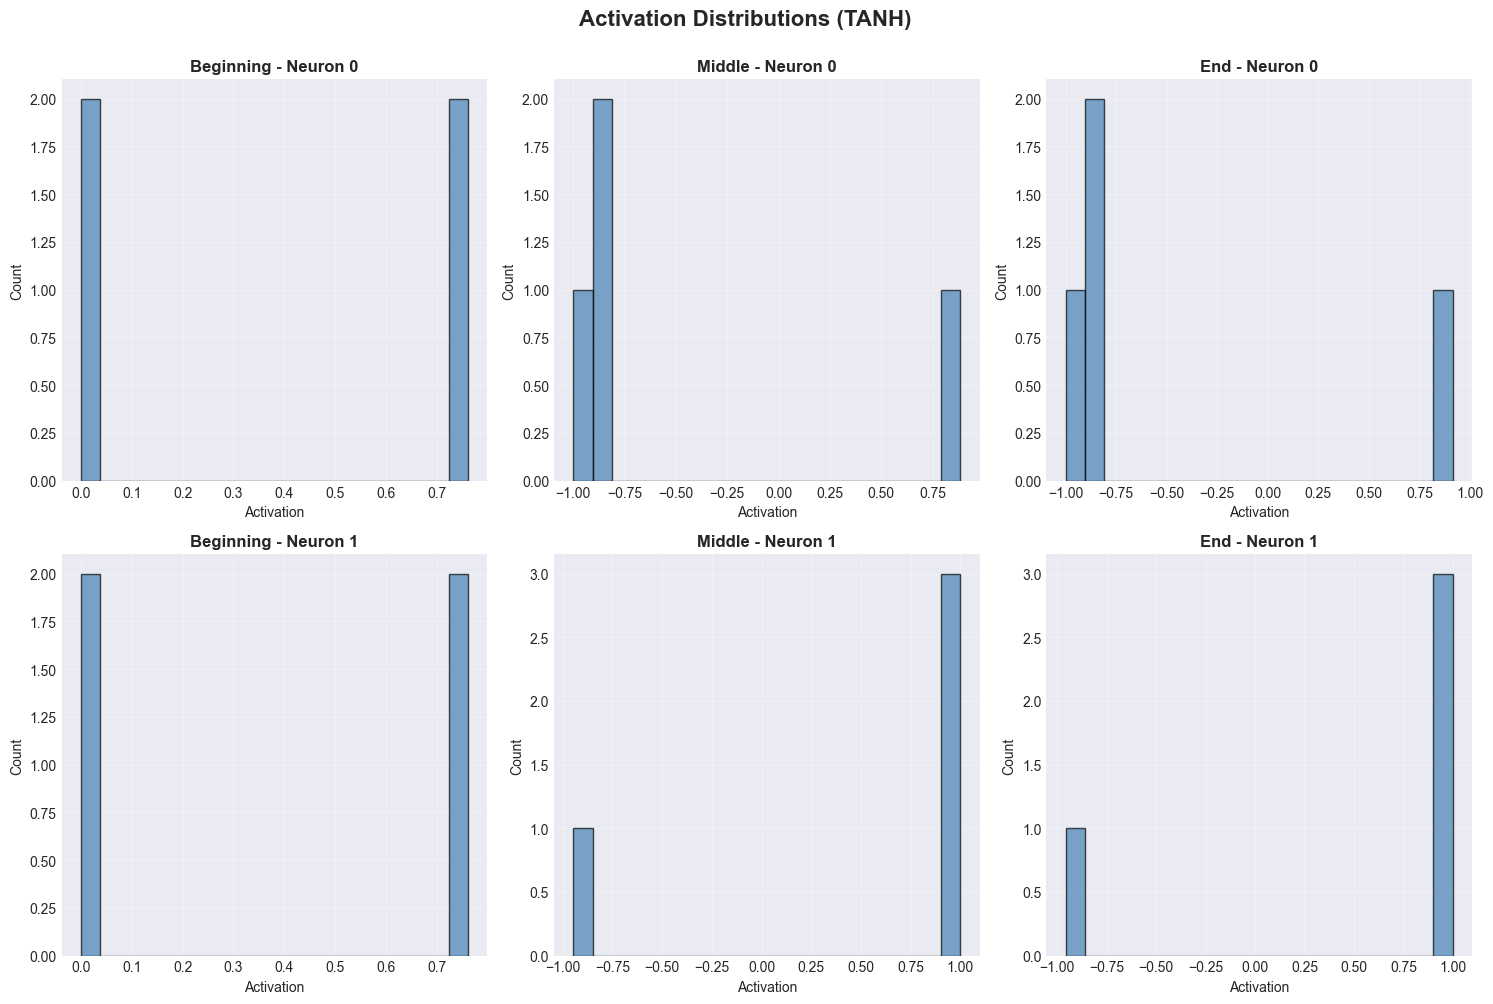

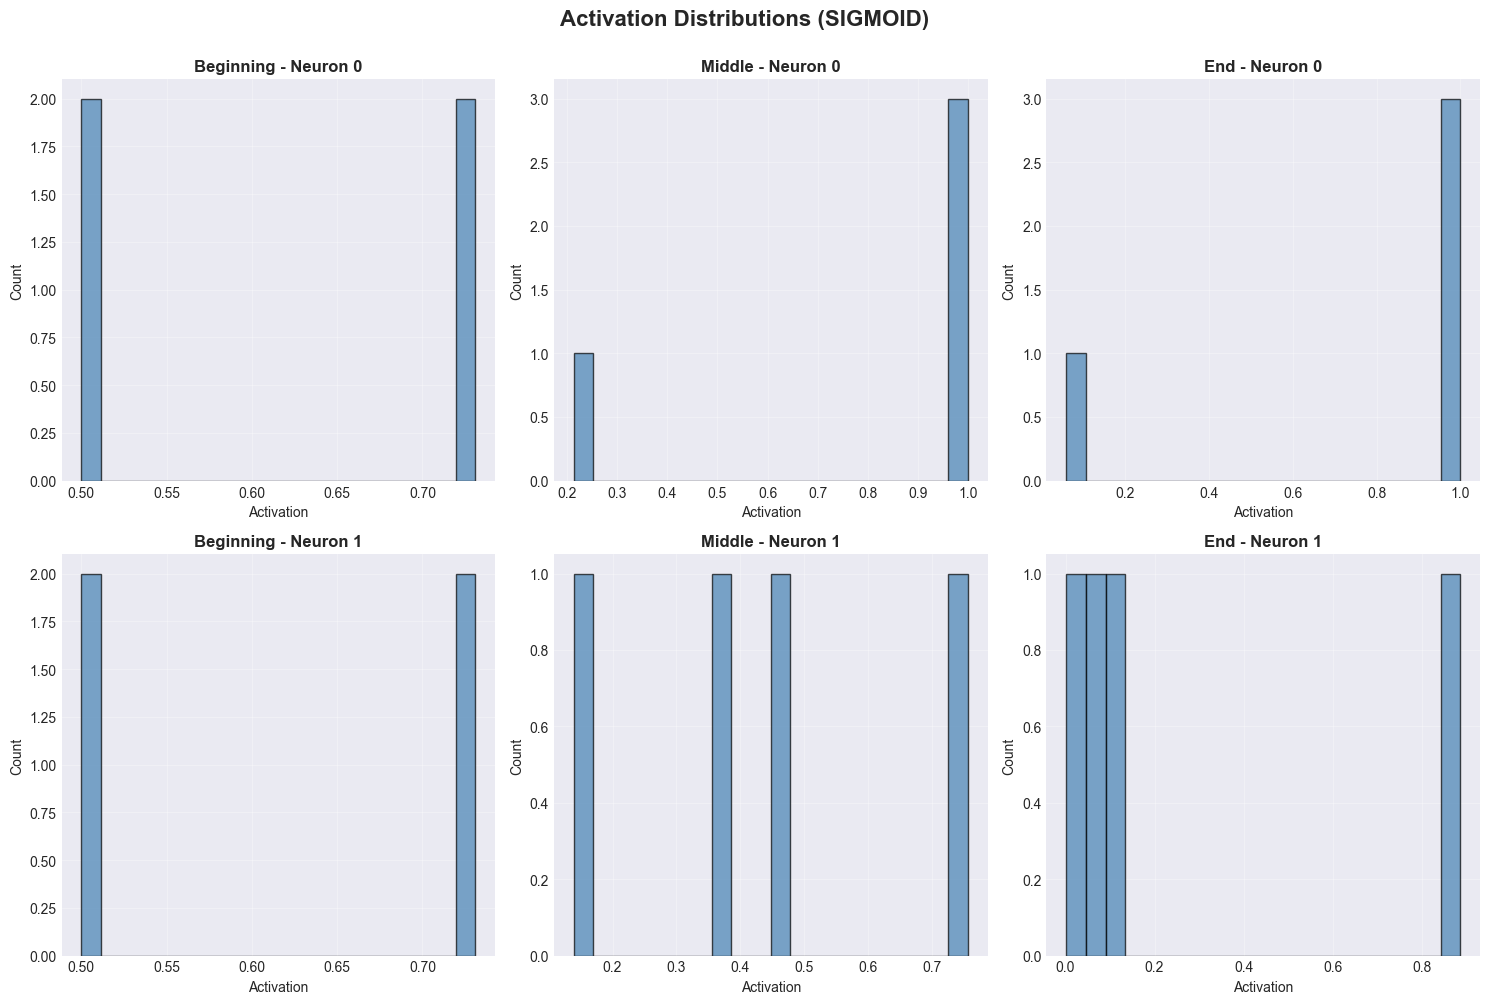

In [23]:
# Compare activation patterns
for activation in activations:
    latent_history = histories[activation].get_latent_tensor()
    fig = plot_activation_histograms(latent_history,
                                     title=f"Activation Distributions ({activation.upper()})")
    plt.show()

## Experiment 2: Noise Robustness

Test how adding noise to inputs or labels affects the learned representations.

In [24]:
console.print("\n[bold cyan]Experiment 2: Noise Robustness[/bold cyan]")

noise_levels = [0.0, 0.05, 0.1, 0.2]
noise_histories = {}

for noise in noise_levels:
    console.print(f"\n[bold]Training with noise level: {noise}[/bold]")

    # Generate noisy data
    x_noisy, y_noisy = generate_xor(noise=noise)

    # Train model
    model = TwoLayerNet(input_dim=2, hidden_dim=2, output_dim=1, activation='relu')
    history = train_model(
        model=model,
        x_data=x_noisy,
        y_data=y_noisy,
        lr=0.1,
        max_epochs=10000,
        threshold=1e-5,
        device=device,
        record_interval=10,
        use_bce=True
    )

    noise_histories[noise] = {
        'history': history,
        'model': model,
        'x_data': x_noisy,
        'y_data': y_noisy
    }

Experiment 2: Noise Robustness

Training with noise level: 0.0

Training on mps...

Output()

Epoch 0: Loss 0.703973, Accuracy 0.5000

Epoch 1000: Loss 0.036474, Accuracy 1.0000

Epoch 2000: Loss 0.011689, Accuracy 1.0000

Epoch 3000: Loss 0.006717, Accuracy 1.0000

Epoch 4000: Loss 0.004664, Accuracy 1.0000

Epoch 5000: Loss 0.003555, Accuracy 1.0000

Epoch 6000: Loss 0.002864, Accuracy 1.0000

Epoch 7000: Loss 0.002394, Accuracy 1.0000

Epoch 8000: Loss 0.002053, Accuracy 1.0000

Epoch 9000: Loss 0.001796, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.001595

Training with noise level: 0.05

Training on mps...

Output()

Epoch 0: Loss 0.699475, Accuracy 0.5000

Epoch 1000: Loss 0.104999, Accuracy 1.0000

Epoch 2000: Loss 0.020161, Accuracy 1.0000

Epoch 3000: Loss 0.010108, Accuracy 1.0000

Epoch 4000: Loss 0.006591, Accuracy 1.0000

Epoch 5000: Loss 0.004841, Accuracy 1.0000

Epoch 6000: Loss 0.003806, Accuracy 1.0000

Epoch 7000: Loss 0.003124, Accuracy 1.0000

Epoch 8000: Loss 0.002645, Accuracy 1.0000

Epoch 9000: Loss 0.002289, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.002015

Training with noise level: 0.1

Training on mps...

Output()

Epoch 0: Loss 0.701062, Accuracy 0.5000

Epoch 1000: Loss 0.479570, Accuracy 0.7500

Epoch 2000: Loss 0.478173, Accuracy 0.7500

Epoch 3000: Loss 0.477843, Accuracy 0.7500

Epoch 4000: Loss 0.477689, Accuracy 0.7500

Epoch 5000: Loss 0.477618, Accuracy 0.7500

Epoch 6000: Loss 0.477566, Accuracy 0.7500

Epoch 7000: Loss 0.477533, Accuracy 0.7500

Epoch 8000: Loss 0.477511, Accuracy 0.7500

Epoch 9000: Loss 0.477496, Accuracy 0.7500

Training finished after 10000 epochs

Final loss: 0.477486

Training with noise level: 0.2

Training on mps...

Output()

Epoch 0: Loss 0.723046, Accuracy 0.5000

Epoch 1000: Loss 0.674217, Accuracy 0.5000

Epoch 2000: Loss 0.674217, Accuracy 0.5000

Epoch 3000: Loss 0.674217, Accuracy 0.5000

Epoch 4000: Loss 0.674217, Accuracy 0.5000

Epoch 5000: Loss 0.674217, Accuracy 0.5000

Epoch 6000: Loss 0.674217, Accuracy 0.5000

Epoch 7000: Loss 0.674217, Accuracy 0.5000

Epoch 8000: Loss 0.674217, Accuracy 0.5000

Epoch 9000: Loss 0.674217, Accuracy 0.5000

Training finished after 10000 epochs

Final loss: 0.674217

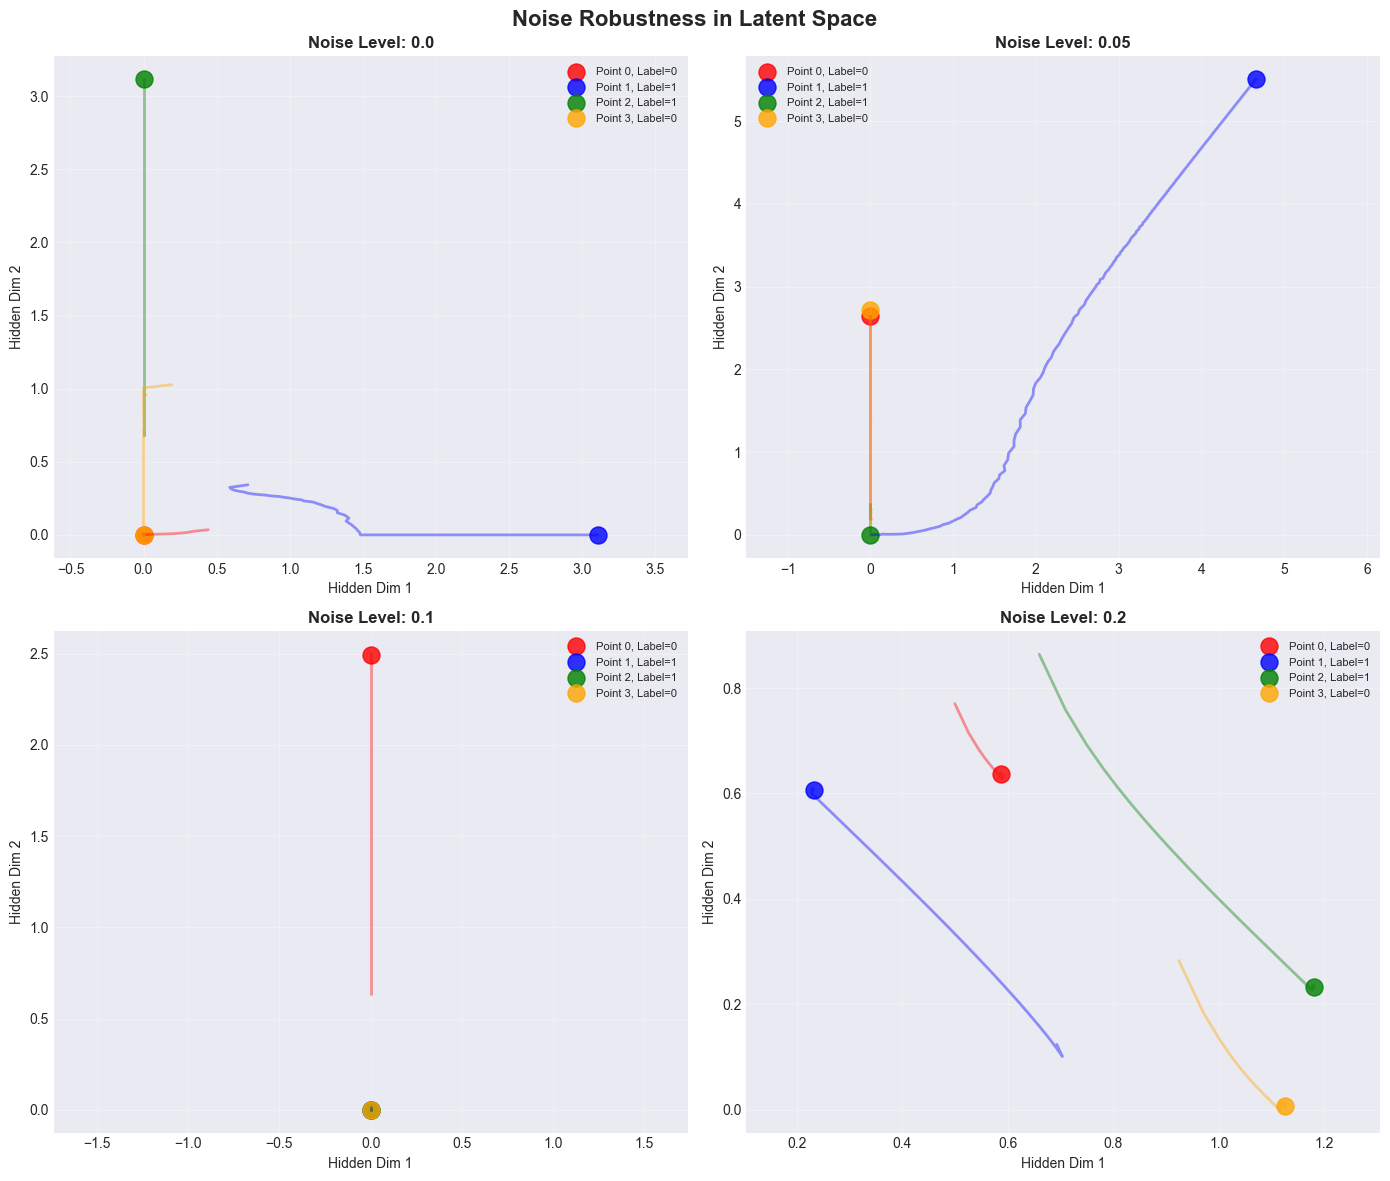

In [25]:
# Visualize noise robustness
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, noise in enumerate(noise_levels):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    data = noise_histories[noise]
    latent_history = data['history'].get_latent_tensor()
    x_noisy = data['x_data']
    y_noisy = data['y_data']

    colors = ["red", "blue", "green", "orange"]
    n_samples = latent_history.shape[1]

    for i in range(n_samples):
        coords = latent_history[:, i, :]
        label_val = int(y_noisy[i].item())

        ax.plot(coords[:, 0], coords[:, 1], color=colors[i],
                alpha=0.4, linewidth=2)
        ax.scatter(coords[-1, 0], coords[-1, 1], color=colors[i],
                   alpha=0.8, marker='o', s=150,
                   label=f"Point {i}, Label={label_val}")

    ax.set_title(f"Noise Level: {noise}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Hidden Dim 1")
    ax.set_ylabel("Hidden Dim 2")
    ax.axis("equal")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Noise Robustness in Latent Space", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Experiment 3: 3-Input XOR with PCA Visualization

Explore higher-dimensional hidden representations using PCA.

Principal Component Analysis (PCA) is a linear dimensionality reduction method that transforms correlated variables into uncorrelated *principal components* capturing maximal variance. Given a zero-mean dataset $X \in \mathbb{R}^{n \times p}$, PCA finds orthogonal directions $w_i$ solving
$$\Sigma w_i = \lambda_i w_i, \quad \text{where } \Sigma = \tfrac{1}{n} X^\top X$$
The eigenvectors $w_i$ define orthogonal axes ordered by decreasing eigenvalues $\lambda_i$, representing explained variance. Equivalently, PCA provides the best rank-$k$ approximation $X \approx U_k S_k V_k^\top$ from the SVD (Singular Value Decomposition) of $X$, retaining maximal information in $k$ dimensions.

In [ ]:
console.print("\n[bold cyan]Experiment 3: 3-Input XOR[/bold cyan]")

# Generate 3-input XOR
x_data_3d, y_data_3d = generate_3input_xor()
console.print(f"3-Input XOR Dataset shape: {x_data_3d.shape}")

# Train with larger hidden layer
model_3d = TwoLayerNet(input_dim=3, hidden_dim=4, output_dim=1, activation='relu')
history_3d = train_model(
    model=model_3d,
    x_data=x_data_3d,
    y_data=y_data_3d,
    lr=0.1,
    max_epochs=10000,
    threshold=1e-5,
    device=device,
    record_interval=10,
    use_bce=True
)

Experiment 3: 3-Input XOR

3-Input XOR Dataset shape: torch.Size([8, 3])

Training on mps...

Output()

Epoch 0: Loss 0.773483, Accuracy 0.5000

Epoch 1000: Loss 0.291156, Accuracy 1.0000

Epoch 2000: Loss 0.067968, Accuracy 1.0000

Epoch 3000: Loss 0.027853, Accuracy 1.0000

Epoch 4000: Loss 0.015894, Accuracy 1.0000

Epoch 5000: Loss 0.010702, Accuracy 1.0000

Epoch 6000: Loss 0.007899, Accuracy 1.0000

Epoch 7000: Loss 0.006179, Accuracy 1.0000

Epoch 8000: Loss 0.005032, Accuracy 1.0000

Epoch 9000: Loss 0.004218, Accuracy 1.0000

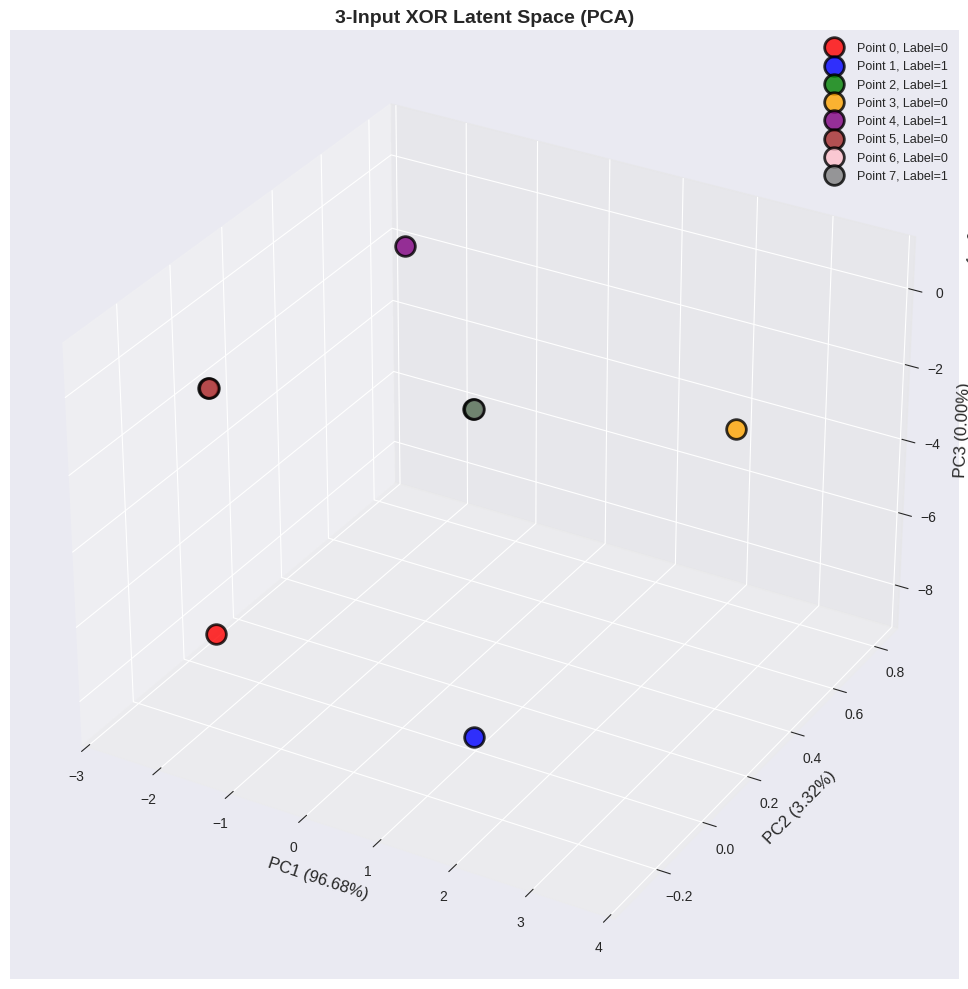

In [18]:
# Visualize with PCA
latent_history_3d = history_3d.get_latent_tensor()
fig = plot_3d_latent_pca(latent_history_3d, y_data_3d,
                         title="3-Input XOR Latent Space (PCA)")
plt.show()

## Experiment 4: Complex Datasets

Test on more complex datasets: Two Moons and Spirals.

In [19]:
console.print("\n[bold cyan]Experiment 4: Complex Datasets[/bold cyan]")

datasets = {
    'Two Moons': generate_two_moons(n_samples=1000, noise=0.1),
    'Spiral': generate_spiral(n_samples=1000, noise=0.2),
    'Circles': generate_circles(n_samples=1000, noise=0.1)
}

complex_results = {}

for name, (x_data_complex, y_data_complex) in datasets.items():
    console.print(f"\n[bold]Training on {name}[/bold]")

    model_complex = TwoLayerNet(input_dim=2, hidden_dim=8, output_dim=1, activation='relu')
    history_complex = train_model(
        model=model_complex,
        x_data=x_data_complex,
        y_data=y_data_complex,
        lr=0.1,
        max_epochs=5000,
        threshold=1e-5,
        device=device,
        record_interval=50,
        use_bce=True
    )

    complex_results[name] = {
        'model': model_complex,
        'history': history_complex,
        'x_data': x_data_complex,
        'y_data': y_data_complex
    }

Experiment 4: Complex Datasets

Training on Two Moons

Training on cuda...

Output()

Epoch 0: Loss 0.714086, Accuracy 0.5000

Epoch 1000: Loss 0.209042, Accuracy 0.9080

Epoch 2000: Loss 0.093838, Accuracy 0.9720

Epoch 3000: Loss 0.043747, Accuracy 0.9910

Epoch 4000: Loss 0.027961, Accuracy 0.9960

Training finished after 5000 epochs

Final loss: 0.020888

Training on Spiral

Training on cuda...

Output()

Epoch 0: Loss 0.703921, Accuracy 0.5000

Epoch 1000: Loss 0.333487, Accuracy 0.8225

Epoch 2000: Loss 0.147323, Accuracy 0.9640

Epoch 3000: Loss 0.104622, Accuracy 0.9700

Epoch 4000: Loss 0.085442, Accuracy 0.9750

Training finished after 5000 epochs

Final loss: 0.069001

Training on Circles

Training on cuda...

Output()

Epoch 0: Loss 0.723133, Accuracy 0.5000

Epoch 1000: Loss 0.203995, Accuracy 0.9950

Epoch 2000: Loss 0.065785, Accuracy 0.9950

Epoch 3000: Loss 0.042612, Accuracy 0.9960

Epoch 4000: Loss 0.033234, Accuracy 0.9960

Training finished after 5000 epochs

Final loss: 0.027999

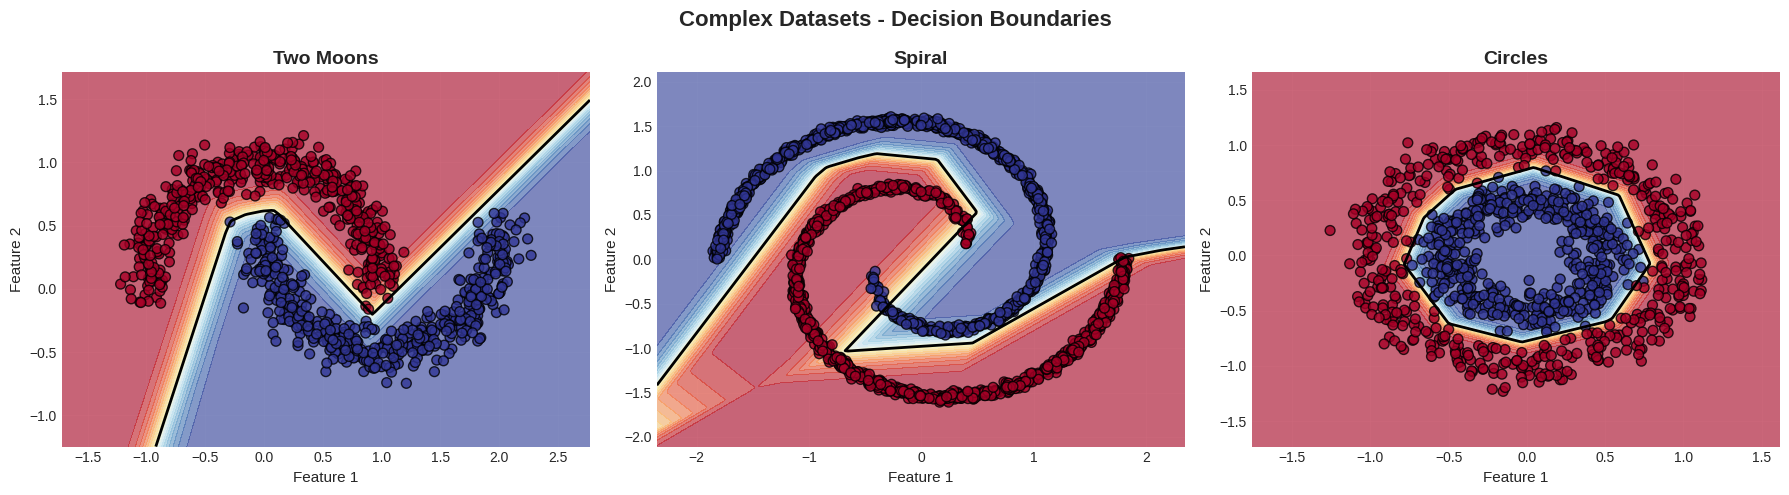

In [20]:
# Visualize complex datasets - Decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(complex_results.items()):
    model = data['model']
    x_data_complex = data['x_data']
    y_data_complex = data['y_data']

    model.eval()

    # Create mesh
    resolution = 200
    x_min, x_max = x_data_complex[:, 0].min() - 0.5, x_data_complex[:, 0].max() + 0.5
    y_min, y_max = x_data_complex[:, 1].min() - 0.5, x_data_complex[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        predictions, _ = model(grid_points)
        predictions = torch.sigmoid(predictions).cpu().numpy()

    predictions = predictions.reshape(xx.shape)

    # Plot
    ax = axes[idx]
    contour = ax.contourf(xx, yy, predictions, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, predictions, levels=[0.5], colors='black', linewidths=2)

    # Data points
    x_np = x_data_complex.cpu().numpy()
    y_np = y_data_complex.cpu().numpy().ravel()
    ax.scatter(x_np[:, 0], x_np[:, 1], c=y_np,
               cmap='RdYlBu', s=50, edgecolors='black',
               linewidths=1, alpha=0.8)

    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel("Feature 1", fontsize=11)
    ax.set_ylabel("Feature 2", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle("Complex Datasets - Decision Boundaries", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

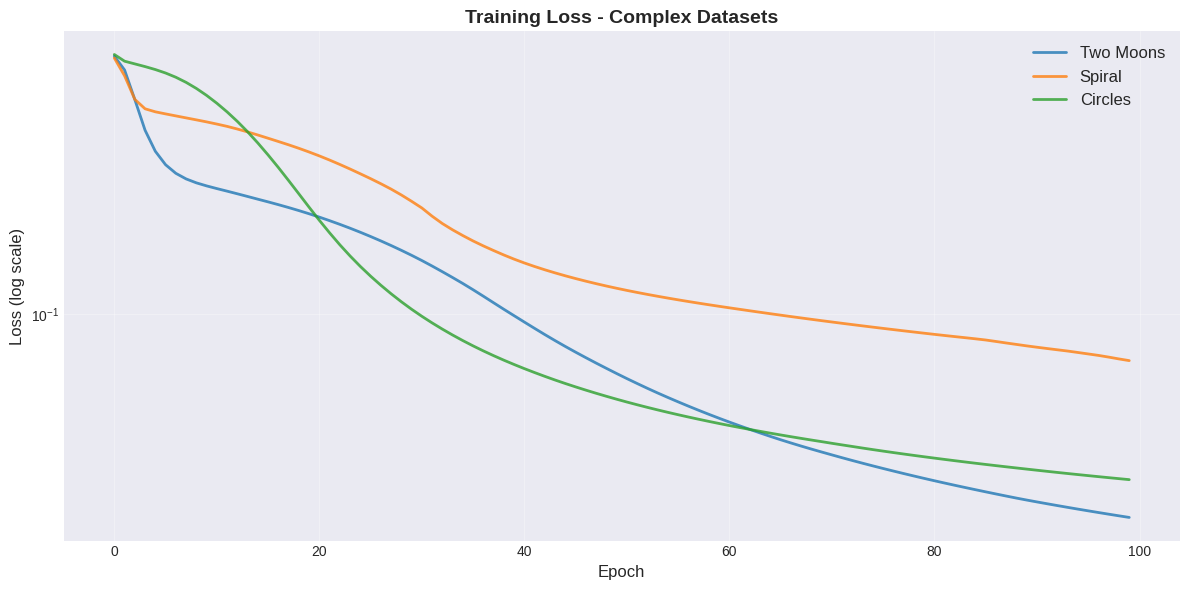

In [21]:
# Loss curves for complex datasets
fig, ax = plt.subplots(figsize=(12, 6))

for name, data in complex_results.items():
    epochs = range(len(data['history'].losses))
    ax.plot(epochs, data['history'].losses,
            linewidth=2, label=name, alpha=0.8)

ax.set_yscale('log')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (log scale)", fontsize=12)
ax.set_title("Training Loss - Complex Datasets", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment 5: Loss Landscape Visualization

Visualize the loss landscape around the final solution.

Experiment 5: Loss Landscape

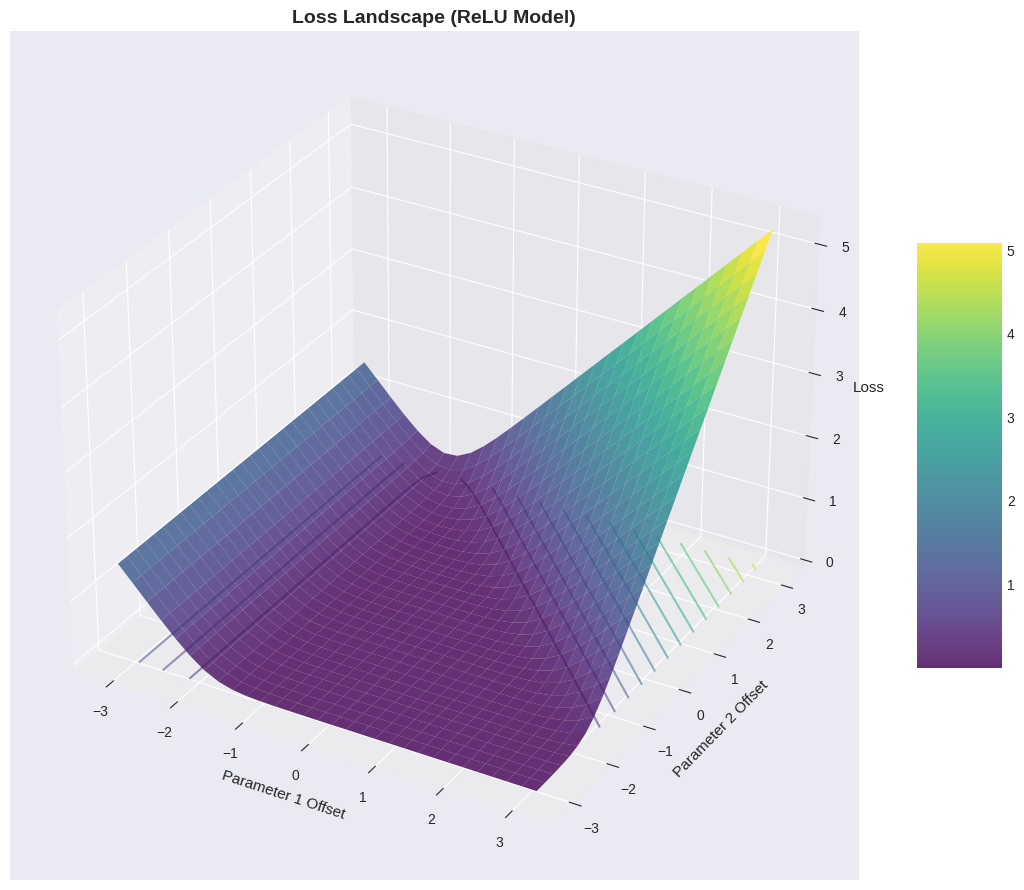

In [22]:
console.print("\n[bold cyan]Experiment 5: Loss Landscape[/bold cyan]")


def compute_loss_landscape(model, x_data, y_data, param_idx=0,
                           range_scale=2.0, resolution=50):
    """Compute 2D loss landscape around current parameters."""
    import torch.nn as nn

    # Get current parameters
    params = list(model.parameters())
    if param_idx >= len(params):
        param_idx = 0

    current_param = params[param_idx].data.clone()

    # Create grid
    param_range = current_param.abs().mean().cpu().item() * range_scale
    if current_param.numel() >= 2:
        x_range = np.linspace(-param_range, param_range, resolution)
        y_range = np.linspace(-param_range, param_range, resolution)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.zeros_like(X)
        criterion = nn.BCEWithLogitsLoss()

        # Compute loss for each point
        for i in range(resolution):
            for j in range(resolution):
                # Modify parameters
                params[param_idx].data = current_param.clone()
                if current_param.numel() >= 2:
                    params[param_idx].data.view(-1)[0] += X[i, j]
                    params[param_idx].data.view(-1)[1] += Y[i, j]

                # Compute loss
                with torch.no_grad():
                    output, _ = model(x_data.to(device))
                    loss = criterion(output, y_data.to(device))
                    Z[i, j] = loss.item()

        # Restore parameters
        params[param_idx].data = current_param

        return X, Y, Z

    return None, None, None


# Compute landscape for ReLU model
model_relu = models['relu']
X, Y, Z = compute_loss_landscape(model_relu, x_data, y_data,
                                 param_idx=0, range_scale=1.0, resolution=30)

if X is not None:
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.contour(X, Y, Z, levels=15, cmap='viridis', linestyles='solid',
               offset=Z.min(), alpha=0.5)

    ax.set_xlabel('Parameter 1 Offset', fontsize=11)
    ax.set_ylabel('Parameter 2 Offset', fontsize=11)
    ax.set_zlabel('Loss', fontsize=11)
    ax.set_title('Loss Landscape (ReLU Model)', fontsize=14, fontweight='bold')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

In [23]:
console.print("\n[bold green]✓ All experiments completed![/bold green]")

✓ All experiments completed!

## Summary and Conclusions
TBD